[<tf.Variable 'dense_8/kernel:0' shape=(5, 32) dtype=float32, numpy=
array([[ 0.03200874, -0.36363   ,  0.22231817, -0.16029146, -0.24501593,
         0.12195742,  0.09607926,  0.3302843 ,  0.2607382 , -0.3098122 ,
        -0.37874737,  0.10825819, -0.04469058,  0.28283334, -0.27651227,
        -0.02628687,  0.17011064, -0.12703419,  0.2112667 ,  0.3484167 ,
        -0.0270873 ,  0.08819476,  0.03404906,  0.38375497,  0.00121403,
         0.28247017,  0.17306334, -0.0891895 ,  0.26115096,  0.22013986,
        -0.26626164, -0.03414601],
       [-0.03031784,  0.35796994,  0.33162826,  0.12563527,  0.03972936,
        -0.35257018,  0.2476896 , -0.22641705,  0.09912229,  0.25915122,
        -0.25569355, -0.0654563 ,  0.29351753,  0.10715693, -0.12600642,
         0.1345765 ,  0.24295479, -0.37966803, -0.08811805,  0.15384066,
         0.1678114 , -0.23119035,  0.25504136, -0.19583048, -0.25731486,
         0.20728022, -0.00118381, -0.29295903, -0.2825145 ,  0.2239008 ,
         0.2069093 ,

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:43<00:00, 1146.28it/s]
C:\Users\New User\AppData\Local\Temp\ipykernel_20008\1567543281.py:184: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.sqrt( results) )


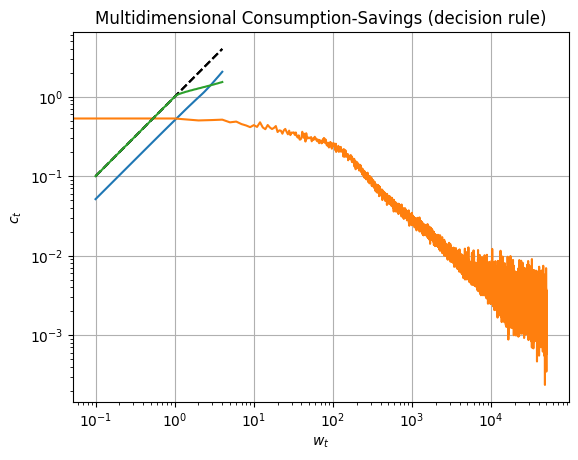

In [15]:
import tensorflow as tf

import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

# Model parameters

β = 0.9 
γ = 2.0 
# σ = 0.1  
# ρ = 0.9
σ_r = 0.001
ρ_r = 0.2
σ_p = 0.0001
ρ_p = 0.999
σ_q = 0.001
ρ_q = 0.9
σ_δ = 0.001
ρ_δ = 0.2
rbar = 1.04


# Standard deviations for ergodic distributions of exogenous state variables
σ_e_r = σ_r/(1-ρ_r**2)**0.5
σ_e_p = σ_p/(1-ρ_p**2)**0.5
σ_e_q = σ_q/(1-ρ_q**2)**0.5
σ_e_δ = σ_δ/(1-ρ_δ**2)**0.5

# bounds for endogenous state variable
wmin = 0.1
wmax = 4.0

# Here is the  Fischer-Burmeister (FB) in TensorFlow:
min_FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)

# construction of neural network
layers = [
    tf.keras.layers.Dense(32, activation='relu', input_dim=5, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

tf.keras.utils.plot_model(perceptron, to_file='model.png', show_shapes=True)

def dr(r: Vector, δ: Vector, q: Vector, p: Vector, w: Vector)-> Tuple[Vector, Vector]:

    # normalize exogenous state variables by their 2 standard deviations 
    # so that they are typically between -1 and 1 
    r = r/σ_e_r/2
    δ = δ/σ_e_δ/2
    q = q/σ_e_q/2
    p = p/σ_e_p/2
    
    # normalze income to be between -1 and 1
    w = (w-wmin)/(wmax-wmin)*2.0-1.0

    # prepare input to the perceptron
    s = tf.concat([_e[:,None] for _e in [r,δ,q,p,w]], axis=1) # equivalent to np.column_stack

    x = perceptron(s) # n x 2 matrix 

    # consumption share is always in [0,1]
    ζ = tf.sigmoid( x[:,0] )
    
    # expectation of marginal consumption is always positive
    h = tf.exp( x[:,1] )
    
    return (ζ, h)

wvec = np.linspace(wmin, wmax, 100)
# r,p,q,δ are zero-mean
ζvec, hvec = dr(wvec*0, wvec*0, wvec*0, wvec*0, wvec)

plt.plot(wvec, wvec, linestyle='--', color='black')
plt.plot(wvec, wvec*ζvec)
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.title("Initial Guess")
plt.grid()

def Residuals(e_r: Vector, e_δ: Vector, e_q: Vector, e_p: Vector, r: Vector, δ: Vector, q: Vector, p: Vector, w: Vector):

    # all inputs are expected to have the same size n
    n = tf.size(r)

    # arguments correspond to the values of the states today
    ζ, h = dr(r, δ, q, p, w)
    c = ζ*w

    # transitions of the exogenous processes
    rnext = r*ρ_r + e_r
    δnext = δ*ρ_δ + e_δ
    pnext = p*ρ_p + e_p
    qnext = q*ρ_q + e_q
    # (epsilon = (rnext, δnext, pnext, qnext))
    
    # transition of endogenous states (next denotes variables at t+1)
    wnext = tf.exp(pnext)*tf.exp(qnext) + (w-c)*rbar*tf.exp(rnext)

    ζnext, hnext = dr(rnext, δnext, qnext, pnext, wnext)
    cnext = ζnext*wnext


    R1 = β*tf.exp(δnext-δ)*(cnext/c)**(-γ)*rbar*tf.exp(rnext) - h
    R2 = min_FB(1-h,1-ζ)

    return (R1, R2)

def Ξ(n): # objective function for DL training

    # randomly drawing current states
    r = tf.random.normal(shape=(n,), stddev=σ_e_r)
    δ = tf.random.normal(shape=(n,), stddev=σ_e_δ)
    p = tf.random.normal(shape=(n,), stddev=σ_e_p)
    q = tf.random.normal(shape=(n,), stddev=σ_e_q)
    w = tf.random.uniform(shape=(n,), minval=wmin, maxval=wmax)
 
    # randomly drawing 1st realization for shocks
    e1_r = tf.random.normal(shape=(n,), stddev=σ_r)
    e1_δ = tf.random.normal(shape=(n,), stddev=σ_δ)
    e1_p = tf.random.normal(shape=(n,), stddev=σ_p)
    e1_q = tf.random.normal(shape=(n,), stddev=σ_q)

    # randomly drawing 2nd realization for shocks
    e2_r = tf.random.normal(shape=(n,), stddev=σ_r)
    e2_δ = tf.random.normal(shape=(n,), stddev=σ_δ)
    e2_p = tf.random.normal(shape=(n,), stddev=σ_p)
    e2_q = tf.random.normal(shape=(n,), stddev=σ_q)
    
    # residuals for n random grid points under 2 realizations of shocks
    R1_e1, R2_e1 = Residuals(e1_r, e1_δ, e1_p, e1_q, r, δ, q, p, w)
    R1_e2, R2_e2 = Residuals(e2_r, e2_δ, e2_p, e2_q, r, δ, q, p, w)

    # construct all-in-one expectation operator
    R_squared = R1_e1*R1_e2 + R2_e1*R2_e2 
    
    # compute average across n random draws
    return tf.reduce_mean(R_squared)

n = 128
v = Ξ(n)
v
v.numpy()

θ = perceptron.trainable_variables
print( str(θ)[:1000] ) # truncate output
from tensorflow.keras.optimizers import Adam, SGD

variables = perceptron.trainable_variables
optimizer = Adam()
# optimizer = SGD(λ=0.1) # SGD can be used in place of Adam

@tf.function
def training_step():

    with tf.GradientTape() as tape:
        xx = Ξ(n)

    grads = tape.gradient(xx, θ)
    optimizer.apply_gradients(zip(grads,θ))

    return xx

def train_me(K):

    vals = []
    for k in tqdm(tf.range(K)):
        val = training_step()
        vals.append(val.numpy())
        
    return vals

# with writer.as_default():
results = train_me(50000)

plt.plot(np.sqrt( results) )
plt.xscale('log')
plt.yscale('log')
plt.grid()

wvec = np.linspace(wmin, wmax, 100)
ζvec, hvec = dr(wvec*0, wvec*0, wvec*0, wvec*0, wvec)

plt.title("Multidimensional Consumption-Savings (decision rule)")
plt.plot(wvec, wvec, linestyle='--', color='black')
plt.plot(wvec, wvec*ζvec)
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.grid()
